# Product Demand Forcaster
In this project we look at product demand forcasting. We are using a dataset that contains a date, product code, warehouse, product_category, and order_demand. we will look at ways of adding value to the dataset through feature engineering. Then will use a couple different models to forcast the demand for a particular product.

Lets import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import matplotlib as plt
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In C:\Users\brand\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\brand\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\brand\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\brand\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\brand\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

Lets read in our dataset to a Pandas DataFrame

In [2]:
#df = pd.read_csv("Historical Product Demand.csv",parse_dates=[3], index_col=3)
df = pd.read_csv("Historical Product Demand.csv")
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


Lets check out the value counts for the products

In [3]:
df['Product_Code'].value_counts()

Product_1359    16936
Product_1295    10575
Product_1378     9770
Product_0620     9428
Product_1286     8888
                ...  
Product_1912        2
Product_0465        1
Product_2099        1
Product_1703        1
Product_0853        1
Name: Product_Code, Length: 2160, dtype: int64

Lets see if we have any null values in the date column

In [4]:
df['Date'].isnull().sum()

11239

we want to fill these empty dates with the previous entries date since it will be close in date.

In [5]:
df.fillna(method='ffill', inplace=True)

We should get rid of the string part of the code so we are just left with numbers. This will make it easier for us to refer to the product code.

In [6]:
df["Product_Code"] = df["Product_Code"].str.strip("Product_")

In [7]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,0993,Whse_J,Category_028,2012/7/27,100
1,0979,Whse_J,Category_028,2012/1/19,500
2,0979,Whse_J,Category_028,2012/2/3,500
3,0979,Whse_J,Category_028,2012/2/9,500
4,0979,Whse_J,Category_028,2012/3/2,500


lets see how many products are going to each warehouse

In [8]:
df["Warehouse"].value_counts()

Whse_J    764447
Whse_A    153574
Whse_S     88200
Whse_C     42354
Name: Warehouse, dtype: int64

lets get a little more familiar with our data

In [9]:
df.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1048575,1048575
unique,2160,4,33,1729,3828
top,1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,481099,2075,112682


lets make 3 seperate columns for month, day and year. we will use this later to help us group our demand by month.

In [10]:
temp = df
temp.head()
temp[["year", "mm", "day"]] = temp['Date'].astype(str).str.split("/", expand=True)

In [11]:
temp.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,year,mm,day
0,0993,Whse_J,Category_028,2012/7/27,100,2012,7,27
1,0979,Whse_J,Category_028,2012/1/19,500,2012,1,19
2,0979,Whse_J,Category_028,2012/2/3,500,2012,2,3
3,0979,Whse_J,Category_028,2012/2/9,500,2012,2,9
4,0979,Whse_J,Category_028,2012/3/2,500,2012,3,2


we want to use a powerful forcasting model called prophet to make forcasts. So we are going to make a dataset that prohpet can handle. We will make a function that takes a product code as an imput and plots the forcasted demand as the output. We also want to show the seasonal trends of the data so it will plot that aswell.

In [12]:
def dailyprophetForcast(prod_code):
    data = temp.drop(columns = ["Warehouse", "Product_Category", "year", "mm","day"])
    data = data[data["Product_Code"] == prod_code]
    data = data.drop(columns=["Product_Code"])
    data.rename(columns={'Order_Demand': 'y', 'Date': 'ds'}, inplace=True)
    data['y'] = data['y'].str.strip('(').str.strip(')').astype(int)
    pht = Prophet()
    pht.fit(data)
    future_prices = pht.make_future_dataframe(periods=365)

    # Predict Prices
    forecast = pht.predict(future_prices)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    
    fig = pht.plot(forecast)
    ax1 = fig.add_subplot(111)
    ax1.set_title("Product Demand Forecast", fontsize=16)
    ax1.set_xlabel("Date", fontsize=12)
    ax1.set_ylabel("Order Demand", fontsize=12)
    fig2 = pht.plot_components(forecast)
    
    

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


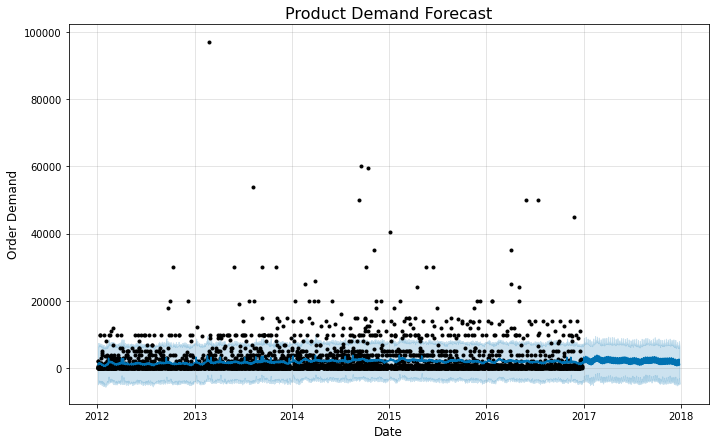

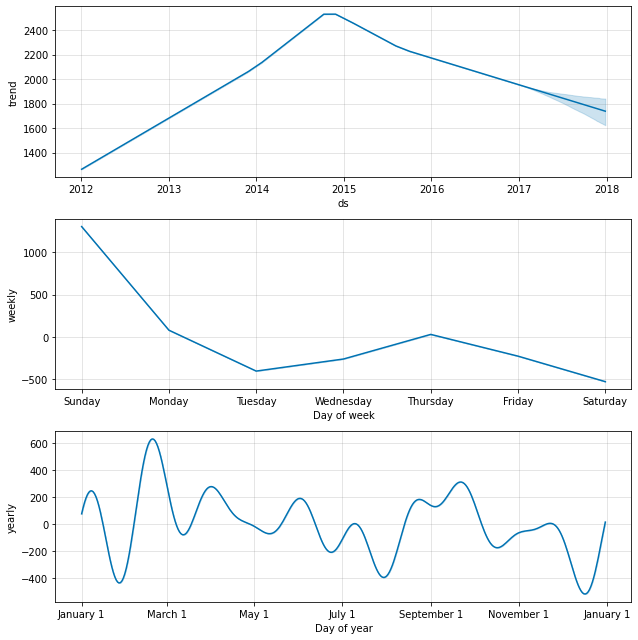

In [13]:
dailyprophetForcast("0979")

we can see from this particular product that the demand is the highest in late January, and has been trending downward the last few years. Our model forcasts that the downard yearly trend will continue.

Next we will try a different forcasting model. we will use a ARIMA model that forcasts the future based on daily values.

In [14]:
def ARIMAdailyForcast(prod_code):
    data = temp.drop(columns = ["Warehouse", "Product_Category", "year", "mm","day"])
    data = data[data["Product_Code"] == prod_code]
    data = data.drop(columns=["Product_Code"])
    data.rename(columns={'Order_Demand': 'y', 'Date': 'ds'}, inplace=True)
    data['y'] = data['y'].str.strip('(').str.strip(')').astype(int)
    pht = Prophet()
    pht.fit(data)
    future_prices = pht.make_future_dataframe(periods=365)
    data.index = data['ds']
    data = data.drop(columns=['ds'])
    model = ARIMA(data, order=(6,1,5))
    model_fit = model.fit(disp = 0)
    # make prediction
    yhat = model_fit.plot_predict(1, len(data)+365)

    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


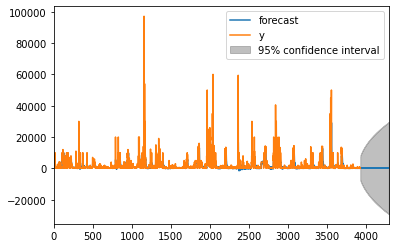

In [15]:
ARIMAdailyForcast("0979")

we can see that this info isn't as helpful to us as the prophets predictions, I think that it might become more helpful if we looked at monthly product demand rather than daily product demand.

Here we will take a product code sum up the orders per month then give it to arima to forcast for us.

In [16]:
def monthlyArimaForcast(prod_code):
    prod_data = temp[temp['Product_Code'] == prod_code].drop(columns = ["Warehouse", "Product_Category", "Date", "day","Product_Code"])
    prod_data["Order_Demand"] = prod_data["Order_Demand"].str.strip('(').str.strip(')').astype(int)
    grouped = prod_data.groupby(['year','mm'])
    monthlydata = pd.DataFrame({"ds":[], "y":[]})
    for date, order in grouped:
        date_str = "" + date[0] + "-" + date[1] + "-1"
        short_data = pd.DataFrame({"ds":[date_str], "y":[order['Order_Demand'].sum()]})
        monthlydata = monthlydata.append(short_data)
    monthlydata = monthlydata.reset_index().drop(columns = ['index'])
    monthlydata.loc[:, 'ds'] = pd.to_datetime(monthlydata.loc[:,'ds'], format="%Y/%m/%d")
    monthlydata.index = monthlydata['ds']
    monthlydata = monthlydata.drop(columns=['ds'])
    model = ARIMA(monthlydata, order=(12,0,12))
    model_fit = model.fit(disp = 0)
    # make prediction
    yhat = model_fit.plot_predict(1, len(monthlydata)+12)
    #print(yhat)
    
    

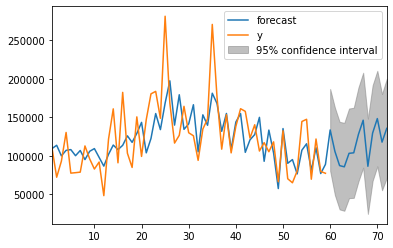

In [17]:
monthlyArimaForcast("0979")

This data looks far more helpful to us than the daily ARIMA predictions. Here we can see some seasonality going on.